In [162]:
import pandas
import pickle
import os
import numpy as n

def read_cached(prefix):
    folder = "/Users/gabriel/Downloads"
    if os.path.isfile(prefix+".pickle"):
        print(f"'{prefix}.pickle' found. Loading it from pickle.")
        return pickle.load(open(prefix+".pickle", "rb"))
    print(f"'{prefix}.pickle' missing. Loading it from xlsx and saving a cached version in pickle.")
    df = pandas.read_excel(os.path.join(folder, prefix+".xlsx"))
    pickle.dump(df, open(prefix+".pickle", "wb"))
    return df

df1 = read_cached("opendata_COD_cause 2000-2008")
df1 = df1.rename(columns={"CD_AGE": "AGE", "COUNT": "DEATH"})
for col in ["CD_RGN_REFNIS", "MS_SEX_", "CHAP_COD"]:
    del df1[col]


df2 = read_cached("DEMO_DEATH_OPEN")
df2 = df2.rename(columns={"CD_AGEGROUP": "AGE", "NR_YEAR": "YEAR", "DT_DATE": "MONTH", "MS_NUM_DEATH": "DEATH"})
df2['MONTH'] = df2['MONTH'].transform(lambda x: x.month)
for col in ["CD_ARR", "CD_PROV", "CD_REGIO", "CD_SEX", "NR_WEEK"]:
    del df2[col]

df = pandas.concat([df1, df2])
df = df.groupby(['MONTH', 'YEAR', 'AGE'], as_index=False).aggregate({'DEATH': 'sum'})
pickle.dump(df, open("death_month_sex_age_2000_2021.pickle", "wb"))

'opendata_COD_cause 2000-2008.pickle' found. Loading it from pickle.
'DEMO_DEATH_OPEN.pickle' found. Loading it from pickle.


In [181]:
import re
import numpy as np

def load_csv(year):
    df = pandas.read_csv(f"/Users/gabriel/Downloads/Belgium-{year}.csv")
    df = df.rename(columns={'Age': 'AGE'})
    df['TOT'] = df['M'] + df['F']
    del df['M']
    del df['F']
    i = lambda s: int(re.search(r'\d+', s).group())
    df['AGE'] = df['AGE'].transform(
        lambda x:['0-24','25-44','45-64','65-74','75-84','85+'][np.argmin(np.array([0,25,45,65,85,200]) < i(x))]
    )
    df = df.groupby('AGE', as_index=False).aggregate({'TOT':'sum'})
    df['YEAR'] = year
    return df
df_tot = pandas.concat([load_csv(year) for year in range(2000,2022)])

      AGE      TOT  YEAR
0    0-24   576032  2000
1   25-44  3147018  2000
2   45-64  3080255  2000
3   65-74  2263301  2000
4   75-84  1158011  2000
..    ...      ...   ...
1   25-44  3365669  2021
2   45-64  3020476  2021
3   65-74  2985714  2021
4   75-84  1501596  2021
5     85+   130241  2021

[132 rows x 3 columns]


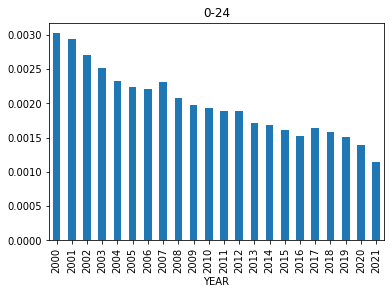

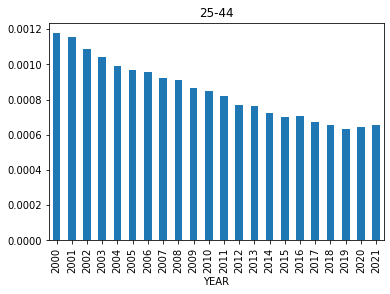

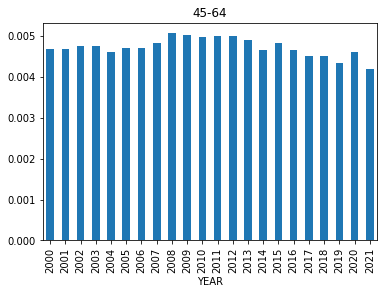

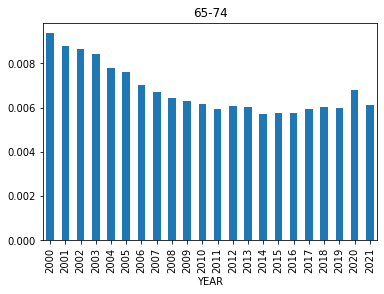

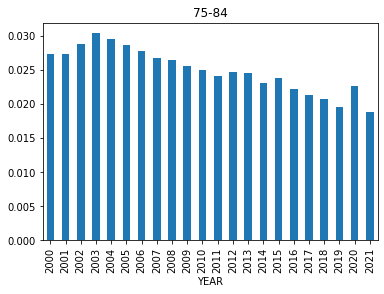

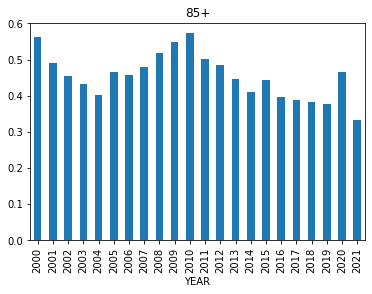

In [193]:
from matplotlib import pyplot as plt

ages = set(df['AGE'])
data = pandas.merge(df.groupby(['YEAR', "AGE"], as_index=False).aggregate({'DEATH':'sum'}), df_tot)
data['RATIO'] = data['DEATH']/data['TOT']
for age in sorted(ages):
    ax = plt.gca()
    ax.set_title(age)
    data[data['AGE']==age].plot(kind='bar', y='RATIO', x='YEAR', ax=ax, legend=False)
    plt.show()